Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# SURE-Based Robust MRI Reconstruction with Diffusion Models (SMRD)
### Setup environment

In [ ]:
!pip install -r ./requirements.txt
%matplotlib inline

### Download demo data and checkpoint
We will download the demo data and checkpoint for the model. Note that the model is trained without taking into consideration of the sparse measurements. In our demo, we will condition the model on the sparse measurements to demonstrate usage of SURE-loss and Conjugate Gradient in the context of Diffusion-based MRI sparse-to-dense reconstruction.

The checkpoint is around 1.7GB, and the demo data is around 20MB.

In [ ]:
# tell if checkpoints/mri-unet-smrd.pth exists or not, if not download it
!ls checkpoints/mri-unet-smrd.pth || (mkdir checkpoints && gdown -O checkpoints/mri-unet-smrd.pth 1NdkK4PDY1PVw4GgNAocYBuZ4_7yCo_hf)
# tell if checkpoints/unet.pt exists or not, if not download it
!ls checkpoints/unet.pt || gdown -O checkpoints/unet.pt 1q4Bc_ZcWAYYX1Y2fs6QanINJ3idNI0cX
# tell if demo_data.pkl.gz exists or not, if not download it
!ls demo_data.pkl.gz || gdown -O demo_data.pkl.gz 1k35KdU2EqnxndV9_7QPw04UhTlxSovNC

### Setup imports and configuration

In [ ]:
import numpy as np
import torch

from monai.config import print_config

from omegaconf import OmegaConf
import pickle, gzip
import matplotlib.pyplot as plt

from mutils import (
    scale,
    get_mvue,
)

from smrd_optimizer import SMRDOptimizer

# load config file
config = OmegaConf.load("configs/demo/SMRD-brain_T2-noise005-R8.yaml")
# setup
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
project_name = config["anatomy"]
rank = 0
config["device"] = rank
sampler = None
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

print_config()

We will use the SMRD optimizer for the reconstruction from sparse MRI scans. The optimizer includes the sampling process that generates the dense MRI reconstruction condioned on sparse meausrements.

The core components of the optimizer are the SURE-based loss and the Conjugate Gradient step.
With the Conjugate Gradient step, we can enforce the generated dense MRI to be consistent with the sparse measurements;
With the SURE-based loss, we can decide when to stop the generation of the dense MRI, to avoid artifacts due to excessive sampling iterations.

Before going into the details of the optmizer and the problem it solves, let's first look at the two building blocks: the Conjugate Gradient step and the SURE-based loss. 

### Conjugate Gradient step
The conjugate gradient (CG) method is an iterative method to solve systems of linear equations. It is particularly useful when the system matrix is large and sparse. The CG method is used to solve the following linear system y=Ax. 
CG method would be particularly useful when the matrix A is large and sparse, where direct methods such as LU decomposition are not feasible.

Let's first look at a toy example about how to use the CG method to solve a linear system below.

In [126]:
# --- A toy example of using Conjugate Gradient ----#
from monai.networks.layers import ConjugateGradient

a_dim = 3
# let's define a simple linear operator

a_mat = torch.tensor([[1, 2, 3], [2, 1, 2], [3, 2, 1]], dtype=torch.float)


def linear_op(x):
    # Here we define the linear operator for conjugate gradient;
    # Note that we do not specify the matrix A explicitly here
    # The linear operator applies as long as it is linear
    # As a result, it could be a convolution, a matrix multiplication, etc.
    res = torch.zeros(a_dim)
    res[0] = 1.0 * x[0] + 2.0 * x[1] + 3.0 * x[2]
    res[1] = 2.0 * x[0] + 1.0 * x[1] + 2.0 * x[2]
    res[2] = 3.0 * x[0] + 2.0 * x[1] + 1.0 * x[2]
    return res


# define a solver with a maximum of 100 iterations
cg_solver = ConjugateGradient(linear_op, num_iter=100)
# define the measurement
y = torch.tensor([1, 2, 3], dtype=torch.float)
# solve for x
x_init = torch.zeros(a_dim)
x = cg_solver(x_init, y)
x_ref = torch.linalg.solve(a_mat, y)
# let's compare the results
diff = torch.norm(x - x_ref)
print(f"The difference between the two solutions is {diff}")

The difference between the two solutions is 1.9371509552001953e-07


We see that the CG iteration converges to a pretty good solution. Although this is a toy example, it illustrates the basic idea: solving a linear system iteratively, without explicitly forming the matrix A. Next we will look at the other building block: SURE loss.

### SURE loss
The Stein's Unbiased Risk Estimator (SURE) is a method to estimate the mean squared error of an estimator. It is particularly useful when the estimator is not known explicitly, but can be sampled from a distribution. The SURE loss is used to estimate the mean squared error of the dense MRI reconstruction, conditioned on the sparse measurements. The SURE loss is used to decide when to stop the generation of the dense MRI, to avoid artifacts due to excessive sampling iterations.

Below, we show a toy example of how to use the SURE loss to estimate the mean squared error of an estimator. In this example, we are assuming that we have a linear measurement model (in fact the SURE loss does not depend on this): y=Ax+n, where A is the measurement matrix, x is the true signal, and n is the noise. However, for some reason, some measurements are missing. As a result, we don't know the ground truth signal x given the measurement matrix A and the corrupted signal, hence we are not able to calculate the MSE loss on the signal. However, we can use the SURE loss to estimate the 'trend' of the MSE loss. 

The toy example described above is a simplified version of sparse MRI reconstruction using iterative optimization/generative method: we have a measurement matrix A - the MRI acquisition model, and we have the corrupted signal - the sparse MRI measurements. We don't know the ground truth signal x, but we can use the SURE loss to estimate the 'trend' of the MSE loss.

Intuitively, in SURE loss calculation, we will use the corrupted signal as the pseudo ground truth. Then we will calculate the divergence of the estimator: if both the difference between the estimator and the pseudo ground truth and the divergence are small, then this indiciates that the MSE is small and vice versa.

Note that, in order to calculate the divergence, we need the input and output of the estimator in the SURE loss to be of same dimension. This is the case for Diffusion-based MRI reconstruction, where the input (diffused image) and output (denoised image) are both with the same image resolution.

Iteration 0, SURE loss: 0.09204394370317459
Iteration 20, SURE loss: 0.086899533867836
Iteration 40, SURE loss: 0.08203018456697464
Iteration 60, SURE loss: 0.07744041085243225
Iteration 80, SURE loss: 0.07311785221099854
Iteration 100, SURE loss: 0.0690443366765976
Iteration 120, SURE loss: 0.0652020275592804
Iteration 140, SURE loss: 0.06157485768198967
Iteration 160, SURE loss: 0.058148324489593506
Iteration 180, SURE loss: 0.054909415543079376


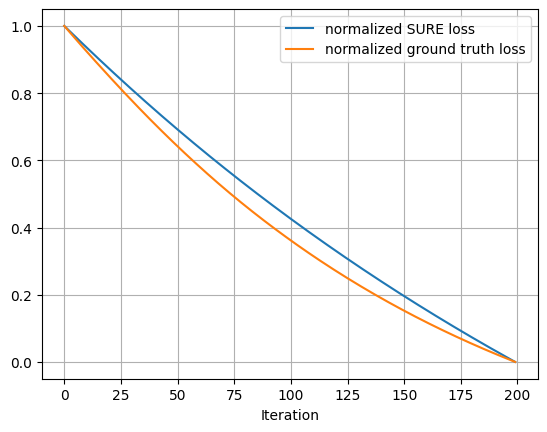

In [162]:
# --- A toy example of using SURE loss ---#
from monai.losses.sure_loss import SURELoss


def generate_invertible_matrix(size):
    random_matrix = torch.rand(size, size)
    mat, _ = torch.linalg.qr(random_matrix)
    return mat


# lets define a simple signal with only 64 dimensions (8x8 image)
dim = 64
# half of the dimensions are missing
zero_out_dim = 32
mat = generate_invertible_matrix(dim).cuda()
mat_inv = torch.linalg.inv(mat)

# define signal, a random 64x1 vector
signal = torch.rand(dim, 1).cuda()
# the ground truth measurement
noise = torch.randn(dim, 1).cuda() * 0.1
measurement = mat @ signal + noise
# zero out some random dimensions
zeroed_measurement = measurement.clone()
dim_index_to_zero = np.random.choice(dim, zero_out_dim, replace=False)
zeroed_measurement[dim_index_to_zero] = 0

signal_zf = mat_inv @ zeroed_measurement

# make signal, measurement 4D
signal = signal.unsqueeze(0).unsqueeze(0)
signal_zf = signal_zf.unsqueeze(0).unsqueeze(0)
measurement = measurement.unsqueeze(0).unsqueeze(0)
zeroed_measurement = zeroed_measurement.unsqueeze(0).unsqueeze(0)

# define the SURE loss
sureloss_metric = SURELoss(
    perturb_noise=torch.rand_like(signal),
    eps=signal_zf.abs().max() / 1000,
)

# we will going to optimize for mat_var
sig_var = torch.nn.Parameter(torch.rand_like(signal))


# define the estimator used by the SURE loss
def estimator(
    x,
):
    return x


# define the optimizer
optimizer = torch.optim.Adam([sig_var], lr=1e-3)
# begin the optimization loop
max_iter = 200
sure_losses, gt_losses = [], []
for i in range(max_iter):
    optimizer.zero_grad()
    sure_loss = sureloss_metric(estimator, x=sig_var, y_pseudo_gt=signal_zf, y_ref=estimator(sig_var))
    sure_loss.backward()
    optimizer.step()

    sure_losses.append(sure_loss.item())
    # get the GT mse loss, where we have access to the ground truth signal
    mse_loss = torch.nn.functional.mse_loss(sig_var, signal)
    gt_losses.append(mse_loss.item())
    if i % 20 == 0:
        print(f"Iteration {i}, SURE loss: {sure_loss.item()}")

# plot the losses
sure_losses = torch.FloatTensor(sure_losses)
gt_losses = torch.FloatTensor(gt_losses)
# normalize the losses seperately to make the trend more readable
sure_losses = (sure_losses - sure_losses.min()) / (sure_losses.max() - sure_losses.min())
gt_losses = (gt_losses - gt_losses.min()) / (gt_losses.max() - gt_losses.min())
plt.plot(sure_losses.detach().squeeze().cpu().numpy(), label="normalized SURE loss")
plt.plot(gt_losses.detach().squeeze().cpu().numpy(), label="normalized ground truth loss")
plt.legend()
plt.xlabel("Iteration")
plt.grid()

We see that even though half of the measurements are missing, the SURE loss is still able to estimate the 'trend' of the MSE loss. Next, we will describe the SMRD algorithm and demonstrate how to use it to reconstruct the dense MRI from the sparse spectral measurements.

### SMRD
As mentioned above, the SMRD algorithm is a generative model that reconstructs the dense MRI from the sparse spectral measurements. The SMRD algorithm includes the SURE-based loss and the Conjugate Gradient step. The SURE-based loss is used to decide when to stop the generation of the dense MRI, to avoid artifacts due to excessive sampling iterations. The Conjugate Gradient step is used to enforce the generated dense MRI to be consistent with the sparse measurements.

The SMRD algorithm deals with two problems:

1. Enforcing the measurement consistency during generation: we need to ensure that the generated dense MRI is consistent with the sparse measurements;

2. Adaptive adjust the weights of the generative and the measurement consistency terms, at the same time, we want to stop the generation when the dense MRI is good enough, rather than overfitting the sparse measurements.

The algorithm is a Diffusion-Model based generative method, which means that it involves multiple generation steps. In each step, according to two problems mentioned above, the algorithm solves the following optimization problem:

\begin{equation}
\min_{x} \left\| Ax - y \right\|_2^2 + \lambda_t \left\| x_t^{+} - x \right\|_2^2
\end{equation}

where $A$ is the inverse measurement matrix for MRI imaging that maps the reconstrcuted image back to the spectral domain; 
$x$ is the dense MRI reconstruction; $y$ is the sparse spectral measurements; $x_t^{+}$ is the previous dense MRI reconstruction with geneartion step; $\lambda_t$ is the weight of the generative term.

The solution to the above optimization problem involves solving a linear system:

\begin{equation}
x_{t+1} = h(x_t, \lambda_t) = (A^H A + \lambda_t I)^{-1} (A^Hy + \lambda_t x_t)
\end{equation}

where $A^H$ is the Hermitian transpose of $A$; $I$ is the identity matrix; $h(x_t, \lambda_t)$ is the Conjugate Gradient step we described above: it solves the linear system with linear operatior $A^H A + \lambda_t I$ iteratively. In dense MRI reconstruction, it is not feasible to build the matrix $A^H A + \lambda_t I$ explicitly, and the CG method is used to solve the linear system efficiently.

To deal with the second problem above, the algorithm uses the SURE-based loss to decide when to stop the generation of the dense MRI. In this case, since $h(x_t, \lambda_t)$, followed by a denoise step maintains the signal's dimension, we can define the estimator in the SURE loss to be the concatenation of those two operations, then use the zero-filled image as the pseudo ground truth to calculate the SURE loss. Since it follows the trend of the MSE loss, we can use it to optimize the weights $\lambda_t$ during test time, and decide when to stop the generation.

In the following, we will first load a pre-trained customized UNet as the score function for denoising. The details of the UNet architecture can be found in the SMRD paper's repo [here](https://github.com/NVlabs/SMRD/blob/01f01dad4510d1b4592c71fdd4880ec767596b87/ncsnv2/models/ncsnv2.py#L198).
The SMRD Optimizer includes the algorithm. 

In [16]:
# load unet strcuture from using torchscript
unet = torch.jit.load("checkpoints/unet.pt")
# initialize SMRD optimizer
SMRD_optimizer = SMRDOptimizer(config, UNet=unet, project_dir="./").to(rank)

### Load data

In [82]:
# load data
with gzip.open("demo_data.pkl.gz", "rb") as f:
    sample = pickle.load(f)

"""
ref: one complex image per coil
mvue: one complex image reconstructed using the coil images and the sensitivity maps
maps: sensitivity maps for each one of the coils
mask: binary valued kspace mask
"""
ref, mvue, maps, mask = sample["ground_truth"], sample["mvue"], sample["maps"], sample["mask"]
mvue, maps, mask = torch.from_numpy(mvue), torch.from_numpy(maps), torch.from_numpy(mask)  # from numpy to torch
ref, mvue, maps, mask = ref.unsqueeze(0), mvue.unsqueeze(0), maps.unsqueeze(0), mask.unsqueeze(0)  # add batch dimension

# move everything to cuda
ref = ref.to(rank).type(torch.complex128)
mask = mask.to(rank)
noise_std = config["noise_std"]
noise = (
    mask[None, :, :] * torch.view_as_complex(torch.randn(ref.shape + (2,)).to(rank)) * noise_std * torch.abs(ref).max()
)

ref = ref + noise.to(rank)
mvue = mvue.to(rank)
maps = maps.to(rank)

estimated_mvue = torch.tensor(
    get_mvue(ref.cpu().numpy(), maps.cpu().numpy()),
    device=ref.device,
)

batch_idx = 0
SMRD_optimizer.config["exp_names"] = [
    "demo",
]
SMRD_optimizer.slice_id = 0

### Run the reconstruction and visualize the results.
The sampling process will take about 8 minutes on a A6000 GPU.

step_size: 1.1689591; error: 291.4465939; mean: 0.7923013; max: 4.5911002; :   4%|▍         | 44/1155 [00:25<09:47,  1.89it/s] 

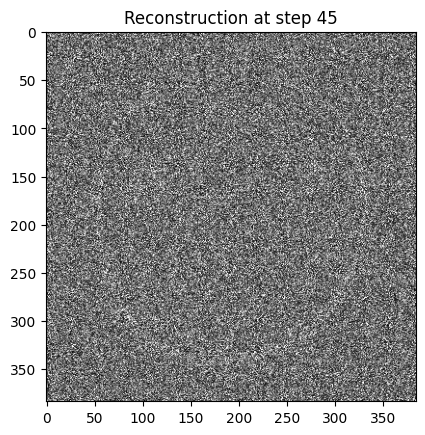

step_size: 0.4722926; error: 205.3659187; mean: 1.2470279; max: 7.8124356; :  12%|█▏        | 144/1155 [01:15<08:59,  1.87it/s]

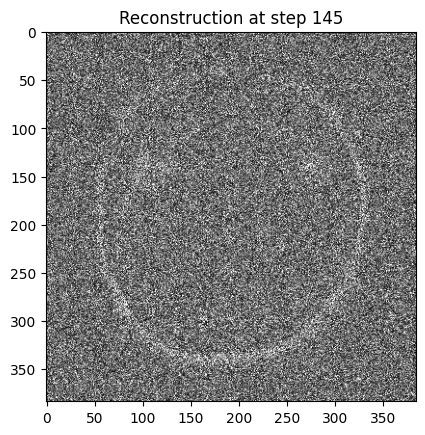

step_size: 0.1908196; error: 159.6978676; mean: 1.9565239; max: 11.0967865; :  21%|██        | 244/1155 [02:06<08:10,  1.86it/s]

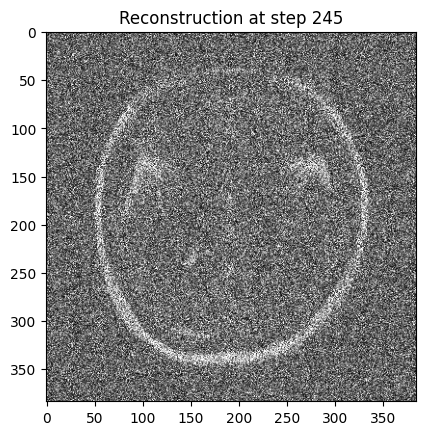

step_size: 0.0770965; error: 135.6457112; mean: 3.0752697; max: 18.3646717; :  30%|██▉       | 344/1155 [02:56<06:40,  2.03it/s]

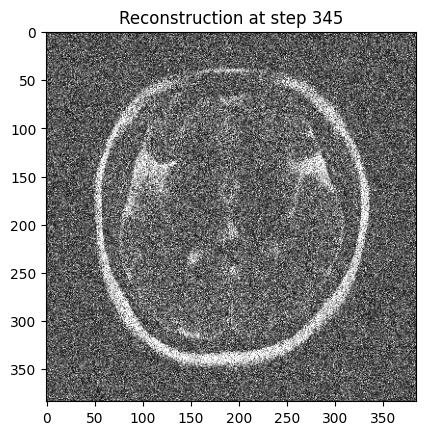

step_size: 0.0311492; error: 125.7301552; mean: 4.8216643; max: 27.7482605; :  38%|███▊      | 444/1155 [03:47<05:54,  2.01it/s]

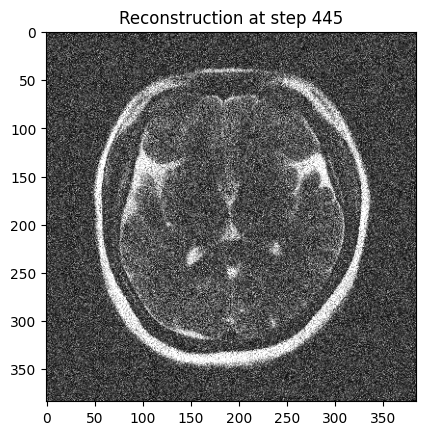

step_size: 0.0125851; error: 121.6272433; mean: 7.5304728; max: 49.1645164; :  47%|████▋     | 544/1155 [04:36<04:34,  2.23it/s]

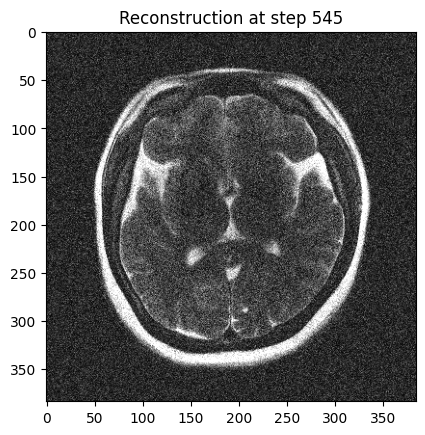

step_size: 0.0050848; error: 120.2523779; mean: 11.7432365; max: 68.3473282; :  56%|█████▌    | 644/1155 [05:22<03:57,  2.15it/s]

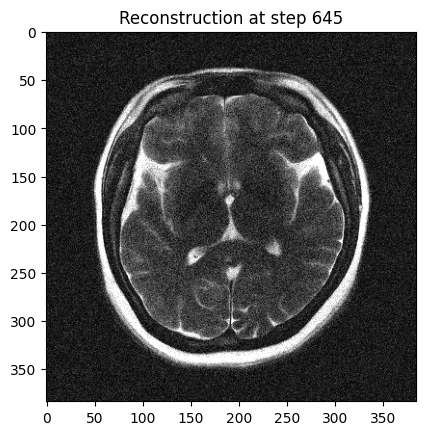

step_size: 0.0020544; error: 119.5284434; mean: 18.0743618; max: 109.5450058; :  64%|██████▍   | 744/1155 [06:22<04:06,  1.67it/s]

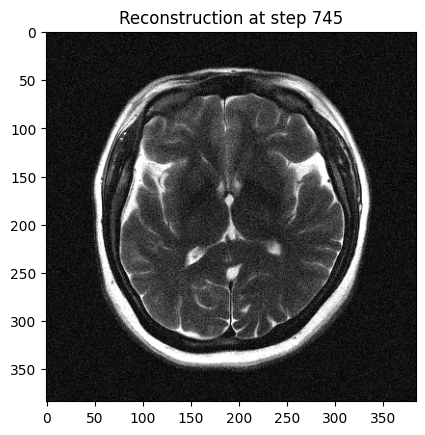

step_size: 0.0008300; error: 119.2840811; mean: 27.2573338; max: 163.6860352; :  73%|███████▎  | 844/1155 [07:24<03:04,  1.69it/s]

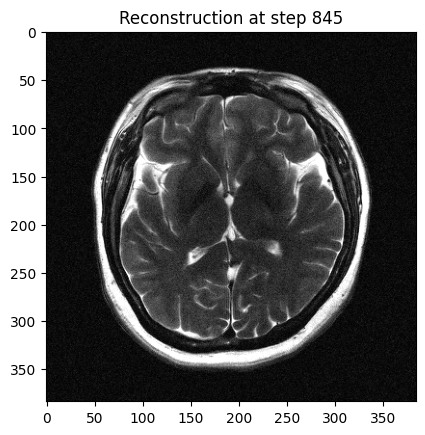

step_size: 0.0006862; error: 119.3176734; mean: 29.5564232; max: 167.6197968; :  75%|███████▍  | 865/1155 [07:36<02:33,  1.90it/s]


Automatic early stopping activated.


In [13]:
# run sampling
outputs = SMRD_optimizer.sample((ref, mvue, maps, mask))

We will visualize the final reconstruction.

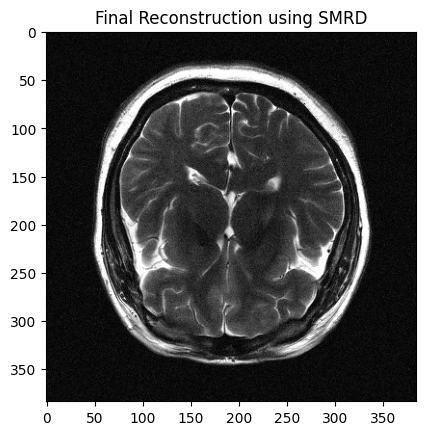

In [14]:
# visualize results
outputs[0] = outputs[0]["mvue"].permute(0, 2, 3, 1)
outputs[0] = torch.view_as_complex(outputs[0])
norm_output = torch.abs(outputs[0]).cpu().numpy()
gt = torch.abs(torch.from_numpy(sample["mvue"])).squeeze(1).cpu().numpy()
img = scale(torch.from_numpy(norm_output))
plt.figure()
plt.imshow(img.cpu().squeeze(0).numpy(), cmap="gray")
plt.title("Final Reconstruction using SMRD")
plt.show()

Compare the results with the ground truth and the zero-filled reconstruction.

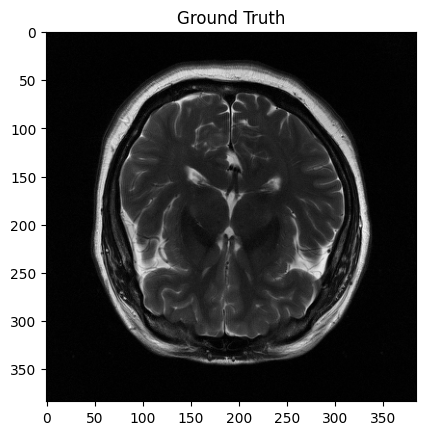

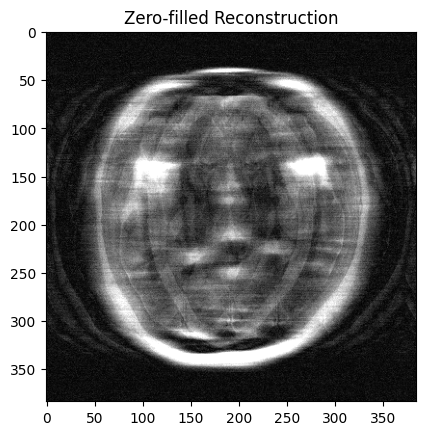

In [15]:
plt.figure()
plt.imshow(gt[0].squeeze(), cmap="gray")
plt.title("Ground Truth")
estimated_mvuevis = torch.abs(estimated_mvue)
estimated_mvuevis = scale(estimated_mvuevis)
estimated_mvue = estimated_mvuevis[batch_idx : batch_idx + 1].abs().flip(-2)
plt.figure()
plt.imshow(estimated_mvue.squeeze(0).cpu().numpy(), cmap="gray")
plt.title("Zero-filled Reconstruction")
plt.show()